# Siamese Neural Networks
Recognize images of icebergs from images of ships. 
These images were taken from space with a Sentinel-4 satellite. The goal was to create the most accurate neural network to differentiate them. However, neural networks usually only work well with A LOT of data, and I constrained you guys to 1000 examples to train on. That seems like a lot, but a CONVENTIONAL neural network needs more data. However, we are going to make a special kind of neural network: *Siamese Network*. This special network is used for face recognition and few-shot learning(learning from few examples). Let's get started by importing the usual liraries:

In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

Using TensorFlow backend.


In [0]:

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the Data


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
npz = np.load('/content/drive/My Drive/Colab Notebooks/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']
del npz
print ('We have {} examples to work with'.format(Y_train.shape[0]-1000))

We have 3113 examples to work with


## Check the data

Load some of the images to observe how your data look like.

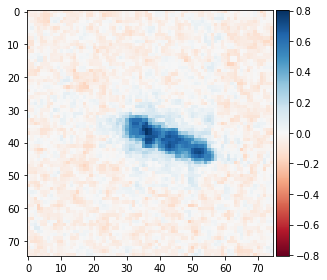

This is: Ship


In [8]:
ix = 100 #0-4112
imshow(np.squeeze(X_train[ix,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']#0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

# Creating the structure of Siamese Network

You just need to break it into some steps:
1. 2 Inputs for each images
2. Creating a network which both images will go through individually
3. Couple the network to each input
4. Calculate the L1 distance between them. Just (x1,y1)-(x2,y2)
5. 1 Added layer that will say 1 if they are the same and 0 if they are different

# Create two Inputs for each image - left_input and right_input
Hint - use Input Function in Keras and keep the shape to be 75,75,3

In [9]:
left_input = Input((75,75,3))
right_input = Input((75,75,3))

W0828 14:31:29.920057 140028842674048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 14:31:29.968116 140028842674048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



# Create a base Network in which both images will go through individually.

Hint - Use Sequential Model in Keras with convolution layers, Maxpooling Layers, Flatten Layer and Denser Layer with appropriate activation functions.
Name the network as base_network

In [10]:
convnet = Sequential([
    Conv2D(5,3, input_shape=(75,75,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])

W0828 14:34:38.622876 140028842674048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 14:34:38.679468 140028842674048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



# Process the left and right inputs to the same Base Network(base_network)

In [0]:
encoded_l = convnet(left_input)

In [0]:
encoded_r = convnet(right_input)

# Get the L1 Distance layer between the 2 processed encodings (processed_a and processed_b)
Hint - You can use Lambda function for this.

In [0]:
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

In [0]:
L1_distance = L1_layer([encoded_l, encoded_r])

# Add the prediction layer in the end and create the Siamese Network using Model function.

In [0]:
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

# Define the Optimizer Adam and Compile the Siamese Model.

In [0]:
optimizer = Adam(0.001, decay=2.5e-4)

# Show the Summary of your Siamese Network

In [17]:
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

W0828 14:39:22.278576 140028842674048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0828 14:39:22.293635 140028842674048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0828 14:39:22.304109 140028842674048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Creating the Pair of Images to train on

It's not time to train though. We still have to create pairs of images to train on. There will be Positive(the same class) or Negative(different classes) for outputs. Let's construct this dataset. It is recommended that there are equal amounts positive and negative.

In [0]:
# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

Now we have a lot more examples.
Now we have pairs x 1000 examples to train the network on. 
Each side will have an input of an image and the output will be one if they are the same and zero if not.

# Train the Siamese train on left and right input image pairs created and validate it by test pairs.

In [19]:
siamese_net.summary()
siamese_net.fit([left_input,right_input], targets,
          batch_size=16,
          epochs=30,
          verbose=1,
          validation_data=([test_left,test_right],test_targets))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 18)           6912        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 18)           0           sequential_1[1][0]               
          

W0828 14:40:30.815472 140028842674048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 5000 samples, validate on 3113 samples
Epoch 1/30
5000/5000 [==============================] - 37s 7ms/step - loss: 0.6822 - acc: 0.5508 - val_loss: 0.6705 - val_acc: 0.5747
Epoch 2/30
5000/5000 [==============================] - 37s 7ms/step - loss: 0.6231 - acc: 0.6572 - val_loss: 0.5404 - val_acc: 0.7761
Epoch 3/30
5000/5000 [==============================] - 37s 7ms/step - loss: 0.5510 - acc: 0.7218 - val_loss: 0.4512 - val_acc: 0.8269
Epoch 4/30
5000/5000 [==============================] - 37s 7ms/step - loss: 0.4909 - acc: 0.7758 - val_loss: 0.4311 - val_acc: 0.8172
Epoch 5/30
5000/5000 [==============================] - 37s 7ms/step - loss: 0.4516 - acc: 0.8056 - val_loss: 0.4302 - val_acc: 0.8037
Epoch 6/30
5000/5000 [==============================] - 37s 7ms/step - loss: 0.4117 - acc: 0.8270 - val_loss: 0.4464 - val_acc: 0.7934
Epoch 7/30
5000/5000 [==============================] - 37s 7ms/step - loss: 0.3856 - acc: 0.8406 - val_loss: 0.5478 - val_acc: 0.7488
Epoch 8